# Data Cleaning

## Python Setup

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import pandas as pd
import numpy as np
import math
import re
from collections import OrderedDict
import random

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation, PCA

seed = 123

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/nj995/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Text Analysis Functions

In [3]:
stop_words = stopwords.words('english')

In [4]:
def create_bag_of_words(corpus, ngram_range = (0, 1), stop_words = None, stem = False,
                        min_df = 0.05, max_df = 0.95, use_idf = False):

    #parameters for vectorizer
    ANALYZER = "word" #unit of features are single words rather then phrases of words
    STRIP_ACCENTS = 'unicode'

    if stem:
        stemmer = nltk.SnowballStemmer("english")
        tokenize = lambda x: [stemmer.stem(i) for i in x.split()]
        stop_words = [tokenize(x)[0] for x in stop_words]
    else:
        tokenize = None
    vectorizer = CountVectorizer(analyzer=ANALYZER,
                                 tokenizer=tokenize,
                                 ngram_range=ngram_range,
                                 stop_words = stop_words,
                                 strip_accents=STRIP_ACCENTS,
                                 min_df = min_df, max_df = max_df)

    bag_of_words = vectorizer.fit_transform(corpus)
    features = vectorizer.get_feature_names()

    if use_idf:
        NORM = None #turn on normalization flag
        SMOOTH_IDF = True #prvents division by zero errors
        SUBLINEAR_IDF = True #replace TF with 1 + log(TF)
        transformer = TfidfTransformer(norm = NORM,smooth_idf = SMOOTH_IDF,sublinear_tf = True)
        #get the bag-of-words from the vectorizer and
        #then use TFIDF to limit the tokens found throughout the text
        tfidf = transformer.fit_transform(bag_of_words)

        return tfidf, features
    else:
        return bag_of_words, features

In [5]:
def get_word_counts(bag_of_words, feature_names):

    # convert bag of words to array
    np_bag_of_words = bag_of_words.toarray()

    # calculate word count.
    word_count = np.sum(np_bag_of_words,axis=0)

    # convert to flattened array.
    np_word_count = np.asarray(word_count).ravel()

    # create dict of words mapped to count of occurrences of each word.
    dict_word_counts = dict( zip(feature_names, np_word_count) )

    # Create ordered dictionary
    orddict_word_counts = OrderedDict( sorted(dict_word_counts.items(), key=lambda x: x[1], reverse=True), )

    return orddict_word_counts


In [6]:
def create_topics(tfidf, features, n_topics=3, n_top_words=5, seed=1):
    
    i=0
    lda = LatentDirichletAllocation(n_components= n_topics,
                                    learning_method='online', random_state=seed) 

    i+=1
    doctopic = lda.fit_transform( tfidf )
    i+=1

    ls_keywords = []
    for i,topic in enumerate(lda.components_):
        word_idx = np.argsort(topic)[::-1][:n_top_words]
        keywords = ', '.join( features[i] for i in word_idx)
        ls_keywords.append(keywords)
        print(i, keywords)
        i+=1

    return ls_keywords, doctopic

## Data Read-In and Corpus Creation

In [7]:
un_speeches = pd.read_csv('../data/un_speeches_2017.csv')
un_speeches['country'] = un_speeches['country'].str.replace('_', ' ')
un_speeches['country'] = un_speeches['country'].str.replace(r'\(.+\)', '')
un_speeches['country'] = un_speeches['country'].str.strip()

# Flag Non-Countries
non_countries = ['European Union', 'President of the General Assembly', 'Secretary-General of the United Nations']
un_speeches = un_speeches[un_speeches['country'].isin(non_countries)==False]

# Choose which text to do the analysis on:
un_speeches['text'] = un_speeches['summary']

un_speeches = un_speeches[un_speeches['text'].notnull()].reset_index(drop=True)

Previous runs used alternative definitions of text:
- `un_speeches['text'] = un_speeches['speech']`
- `un_speeches['text'] = np.where(un_speeches['speech'].notnull(), un_speeches['speech'], un_speeches['summary'])`

In [8]:
countries_info = pd.read_csv('../data/complements/countries of the world.csv')
countries_info.columns = [col.lower() for col in list(countries_info)]
countries_info.rename(columns={'area (sq. mi.)':'area', 'gdp ($ per capita)':'gdp_per_capita'}, inplace=True)
countries_info = countries_info[['country', 'region', 'area', 'gdp_per_capita']]
countries_info['country'] = countries_info['country'].str.strip()
countries_info['country'] = countries_info['country'].str.replace('&', 'and')
countries_info['country'] = countries_info['country'].str.replace(r', The$', '')
countries_info['country'] = countries_info['country'].str.replace(r', Fed\. St\.$', '')
countries_info['country'] = countries_info['country'].str.replace(r'^Brunei$', 'Brunei Darussalam')
countries_info['country'] = countries_info['country'].str.replace(r'^Cape Verde$', 'Cabo Verde')
countries_info['country'] = countries_info['country'].str.replace(r'^Vietnam$', 'Viet Nam')
countries_info['country'] = countries_info['country'].str.replace(r'^United States$', 'United States of America')
countries_info['country'] = countries_info['country'].str.replace(r'^United Kingdom$', 'United Kingdom of Great Britain and Northern Ireland')
countries_info['country'] = countries_info['country'].str.replace(r'^Tanzania$', 'United Republic of Tanzania')
countries_info['country'] = countries_info['country'].str.replace(r'^Syria$', 'Syrian Arab Republic')
countries_info['country'] = countries_info['country'].str.replace(r'^Russia$', 'Russian Federation')
countries_info['country'] = countries_info['country'].str.replace(r'^Korea, North$', "Democratic People's Republic of Korea")
countries_info['country'] = countries_info['country'].str.replace(r'^Korea, South$', 'Republic of Korea')
countries_info['country'] = countries_info['country'].str.replace(r'^Burma$', 'Myanmar')
countries_info['country'] = countries_info['country'].str.replace(r'^Moldova$', 'Republic of Moldova')
countries_info['country'] = countries_info['country'].str.strip()
countries_info['region'] = countries_info['region'].str.strip()
countries_info['continent'] = np.where(
    countries_info['region'].isin(['WESTERN EUROPE', 'EASTERN EUROPE', 'BALTICS', 'C.W. OF IND. STATES']), "EUROPE", np.where(
        countries_info['region'].isin(['SUB-SAHARAN AFRICA', 'NORTHERN AFRICA']), "AFRICA", np.where(
            countries_info['region'].isin(['LATIN AMER. & CARIB']), "SOUTH AMERICA & CARIB", np.where(
                countries_info['region'].isin(['ASIA (EX. NEAR EAST)', 'NEAR EAST']), "ASIA", np.where(
                    countries_info['region'].isin(['OCEANIA']), "OCEANIA", np.where(
                        countries_info['region'].isin(['NORTHERN AMERICA']), "NORTH AMERICA", np.nan
                    )
                )
            )
        )
    )
)

In [9]:
un_speeches = pd.merge(un_speeches, countries_info, how='left', on='country')
print(un_speeches.shape)

(195, 8)


In [10]:
countries = list(un_speeches['country'].values)

In [11]:
corpus = un_speeches['text'].values

## Corpus Cleaning

In [12]:
# Removing non-alpha elements
corpus = np.array([re.sub(r'\W+|\d+', ' ', elem).lower() for elem in corpus])

# Remove one-character words:
corpus = np.array([re.sub(r'\b\w\b', ' ', elem).lower() for elem in corpus])

# Remove extra spacing:
corpus = np.array([re.sub(r'\s+', ' ', elem) for elem in corpus])

## Summary Statistics

In [13]:
bag_of_words, features = create_bag_of_words(corpus=corpus, stop_words=stop_words, min_df=0.0, max_df=1.0,
                                             stem=True, ngram_range=(1,2), use_idf=False)
word_count = get_word_counts(bag_of_words, features)

In [14]:
# Top words overall
pd.Series(word_count).head(10)

said           1078
countri         692
nation          676
unit            547
develop         504
state           476
intern          430
would           424
unit nation     419
peopl           401
dtype: int64

## Comparison Example of USA and France:

In [15]:
# Use the correct spelling of state in data
country_1 = "United States of America"
country_2 = "France"

In [16]:
index_1 = int(un_speeches[un_speeches['country']==country_1].index.values)
index_2 = int(un_speeches[un_speeches['country']==country_2].index.values)
corpus_subset = list(corpus[i] for i in [index_1, index_2])

In [17]:
index_1 = int(un_speeches[un_speeches['country']==country_1].index.values)
index_2 = int(un_speeches[un_speeches['country']==country_2].index.values)
corpus_subset = list(corpus[i] for i in [index_1, index_2])

bag_of_words, features = create_bag_of_words(corpus_subset, stop_words=stop_words, min_df=0.0, max_df=1.0,
                                             stem=True, ngram_range=(1,2), use_idf=True)
df = pd.DataFrame({
    'word' : np.asarray(features)
    , 'country_1': bag_of_words.toarray()[0]
    , 'country_2': bag_of_words.toarray()[1]
})

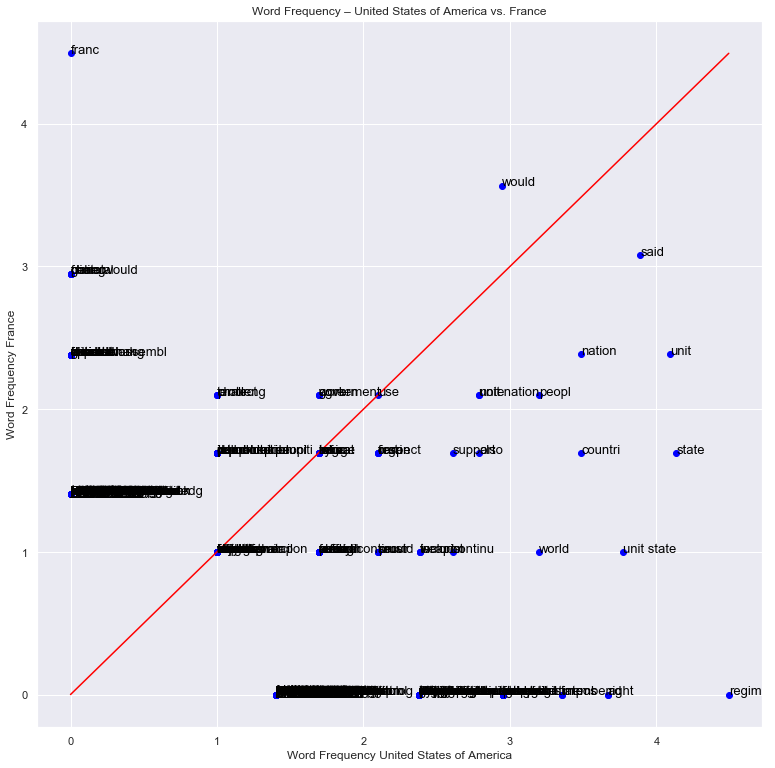

In [18]:
x_plot = df['country_1']
y_plot = df['country_2']
labels_plot = df['word']

max_count = max(max(x_plot), max(y_plot))
min_max = min(max(x_plot), max(y_plot))

fig, ax = plt.subplots(1, 1, figsize = (13,13))
plt.scatter(x_plot, y_plot, color='blue')
plt.plot([0, min_max], [0, min_max], '-', color = 'red')

for i, j, k in zip(x_plot, y_plot, labels_plot):
    ax.annotate('%s' %k, xy = (i,j), fontsize = 13, color = 'black');

ax.set_title('Word Frequency – {} vs. {}'.format(country_1, country_2))
plt.xlabel('Word Frequency {}'.format(country_1))
plt.ylabel('Word Frequency {}'.format(country_2))
plt.show()

## PCA on TF-IDF Word Frequencies

In [19]:
corpus_bag_of_words, corpus_features = create_bag_of_words(corpus, stop_words=stop_words, 
                                                           min_df=0.1, max_df=0.9,
                                                           stem=True, ngram_range=(0,2), use_idf=True)

In [20]:
df = pd.DataFrame(corpus_bag_of_words.toarray())
df.columns = corpus_features

In [21]:
pca = PCA(n_components=2)
pca.fit(df)

bag_of_words_pca = pd.DataFrame(pca.transform(df))
bag_of_words_pca = pd.concat([un_speeches[['country', 'region', 'continent', 'area', 'gdp_per_capita']], bag_of_words_pca], axis=1)
bag_of_words_pca.rename(columns={0:'PCA_Axis_1', 1:'PCA_Axis_2'}, inplace=True)

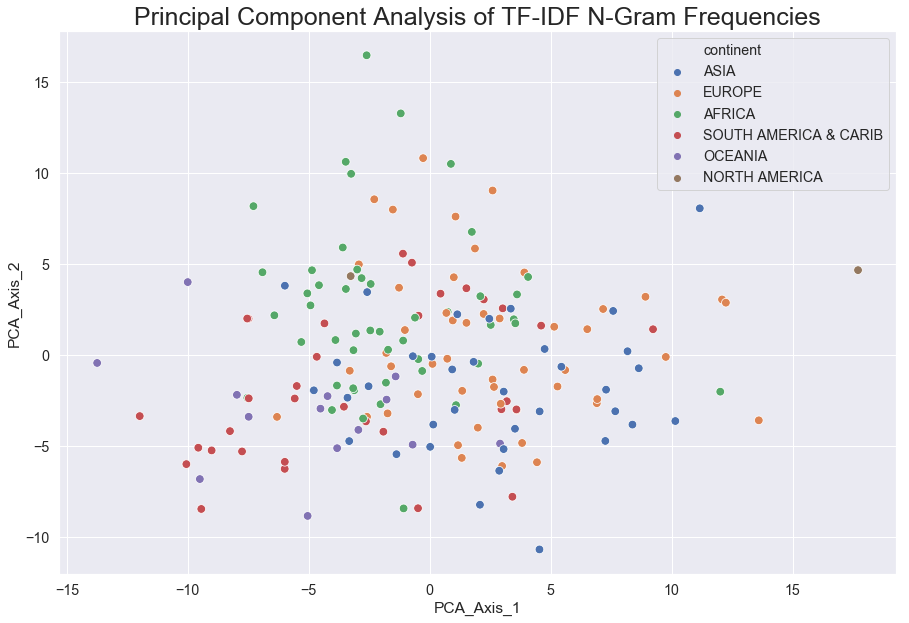

In [28]:
sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(ax=ax, x=bag_of_words_pca['PCA_Axis_1'], y=bag_of_words_pca['PCA_Axis_2'], 
                hue=bag_of_words_pca['continent'], s=75)
ax = plt.gca()
ax.set_title("Principal Component Analysis of TF-IDF N-Gram Frequencies",  {'fontsize': 25})
plt.savefig('../output/figures/pca_fig1.png', bbox_inches='tight')
plt.show()

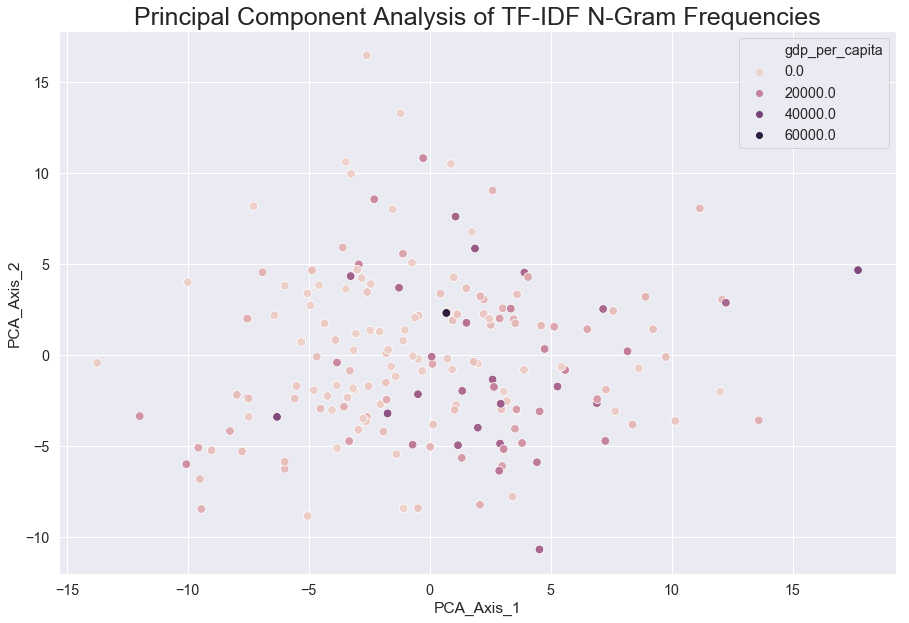

In [29]:
sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(ax=ax, x=bag_of_words_pca['PCA_Axis_1'], y=bag_of_words_pca['PCA_Axis_2'], 
                hue=bag_of_words_pca['gdp_per_capita'], s=75)
ax.set_title("Principal Component Analysis of TF-IDF N-Gram Frequencies",  {'fontsize': 25})
plt.savefig('../output/figures/pca_fig2.png', bbox_inches='tight')
plt.show()

## Latent Dirichlet Allocation Topic Modeling

In [31]:
corpus_bag_of_words, corpus_features = create_bag_of_words(corpus, stop_words=stop_words, min_df=0.1, max_df=0.9,
                                                           stem=True, ngram_range=(1,2), use_idf=True)

In [32]:
# Simple LDA Model
simple_keywords, simple_corpus_doctopic = create_topics(corpus_bag_of_words, corpus_features, 
                                                        n_top_words=5, seed=seed)

0 state, peopl, unit, terror, intern
1 develop, african, sustain, would, also
2 island, develop, small, climat, small island


In [33]:
# After further Analysis, this distribution seems most relevant
ls_corpus_keywords, corpus_doctopic = create_topics(corpus_bag_of_words, corpus_features, 
                                                    n_topics=8, n_top_words=12, seed=seed)

0 uniti, said emphas, time, stabil, libya, root, negoti, base, must, comprehens, solut, freedom
1 develop, secur, also, implement, intern, sustain, unit, unit nation, peac, call, support, note
2 island, small island, small, caribbean, ocean, develop, island develop, hurrican, climat, develop state, climat chang, sustain
3 develop, global, unit nation, africa, african, unit, would, challeng, work, sustain, world, secur
4 unit, must, unit state, human, sovereignti, right, human right, nuclear, weapon, peopl, express, use
5 counter terror, freedom, counter, terror, terrorist, migrant, welcom, describ, asia, year, europ, civil
6 terrorist, territori, terror, solut, yemen, support, state, east, polit, intern, palestinian, region
7 republ, korea, republ korea, nuclear, democrat, democrat peopl, peopl republ, korean, east, missil, peninsula, peopl


### Topic Interpretation

Which topics seem to make sense?

In [34]:
# Replace this with Relevant Topic Numbers
relevant_topic_list = [
    # 0,
    1, 2, 3, 4, 
    # 5, 
    6, 7
]
topic_themes = [
    #0
    'Peace & Security', #1
    'Climate Change', #2
    'Development', #3
    'Human Rights', #4
    #5
    'Arab World', #6
    'North Korea' #7
]
relevant_topics = pd.DataFrame({'topic': relevant_topic_list, 'theme': topic_themes})

### Assigning a Dominant Topic

Overall, and among the topics that "make sense", which is the dominant topic for each speech?

In [35]:
df = pd.DataFrame(data = corpus_doctopic)

In [36]:
# Overall Dominant Topic
df = pd.DataFrame(data = corpus_doctopic)
dom_topic = np.asarray(df.idxmax(axis=1))
dom_topic_pct = np.asarray(df.max(axis = 1))

In [37]:
# Dominant Topic among relevant Topics
relevant_corpus_doctopic = corpus_doctopic[:, relevant_topic_list]
df = pd.DataFrame(data = relevant_corpus_doctopic)
dom_relevant_topic = np.asarray(df.idxmax(axis=1))
mapping = np.vectorize(lambda t: relevant_topic_list[t])
dom_relevant_topic = mapping(dom_relevant_topic)
dom_relevant_topic_pct = np.asarray(df.max(axis = 1))

In [38]:
df = pd.DataFrame({
    'country': np.asarray(countries)
    , 'dom_topic': dom_topic
    , 'dom_topic_pct': dom_topic_pct
    , 'dom_relevant_topic': dom_relevant_topic
    , 'dom_relevant_topic_pct': dom_relevant_topic_pct
})
df = pd.merge(df, relevant_topics.rename(columns={'topic':'dom_relevant_topic', 'theme':'dom_theme'}), 
              how='left', on='dom_relevant_topic')

In [39]:
# Add all other topics:
df = pd.concat([df, pd.DataFrame(data=corpus_doctopic)], axis=1)

In [40]:
df.to_csv('../output/speech_topics_2017.csv', index=False)

### Plots

In [90]:
def plot_bar(freq, var1, var2, title, filename):
    sns.set(font_scale=1.3)
    fig, ax = plt.subplots(figsize=(15, 7))
    sns.barplot(x=var1, y=var2, data=freq, color=sns.color_palette()[0])
    ax.set_title(title, fontdict={'fontsize': 25})
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
    plt.savefig('../output/figures/{}.png'.format(filename), bbox_inches='tight')

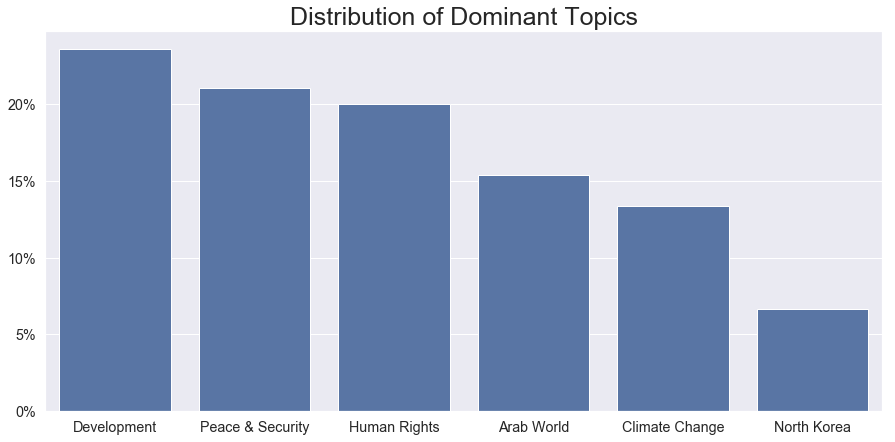

In [91]:
freq = pd.DataFrame(df['dom_theme'].value_counts(normalize=True)).reset_index()
plot_bar(freq, 'index', 'dom_theme', 'Distribution of Dominant Topics', 'dom_top_fig1')

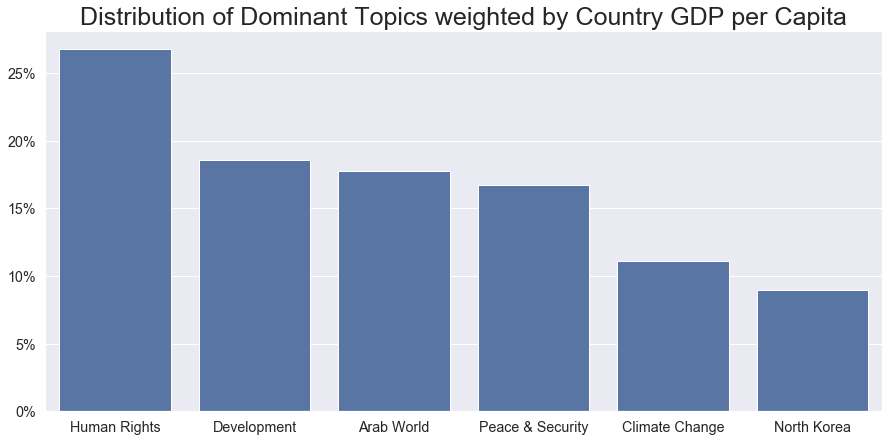

In [92]:
freq = df[['country', 'dom_theme']]
freq = pd.merge(freq, countries_info, how='left', on='country')
normalizer = freq['gdp_per_capita'].sum()
freq = freq.groupby('dom_theme')['gdp_per_capita'].sum().reset_index()
freq['value'] = freq['gdp_per_capita']/normalizer
freq = freq.sort_values('value', ascending=False)
plot_bar(
    freq, 'dom_theme', 'value', 'Distribution of Dominant Topics weighted by Country GDP per Capita', 'dom_top_fig2'
)

#### Robustness Check: Using Probabilities

In [93]:
value_vars = [col for col in list(df) if type(col)==int]
weights = pd.melt(df, id_vars=['country'], value_vars=value_vars)
weights = pd.merge(weights, countries_info, how='left', on='country')
weights['weighted_value'] = weights['value']*weights['gdp_per_capita']

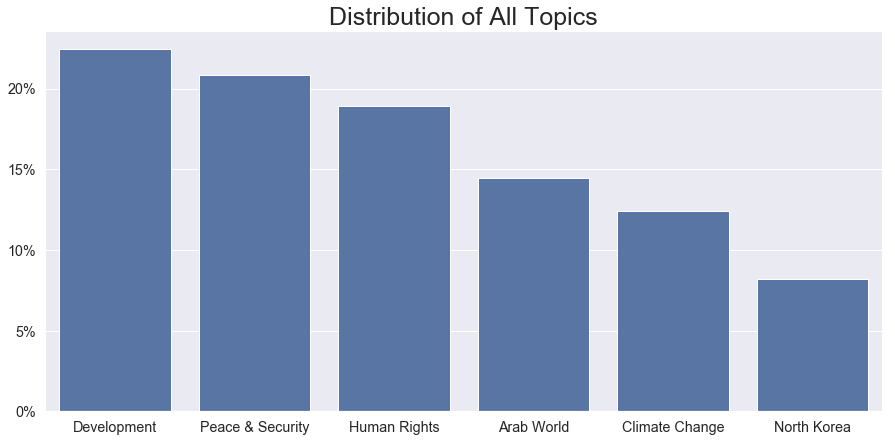

In [94]:
freq = weights.groupby('variable')
freq = pd.DataFrame({
    'value': freq['value'].sum()
    , 'nb_countries': freq['country'].count()
}).reset_index()
freq['value'] = freq['value']/freq['nb_countries']
freq.rename(columns={'variable': 'topic'}, inplace=True)
freq = pd.merge(freq, relevant_topics, how='inner', on='topic').sort_values('value', ascending=False)
plot_bar(freq, 'theme', 'value', 'Distribution of All Topics', 'all_top_fig1')

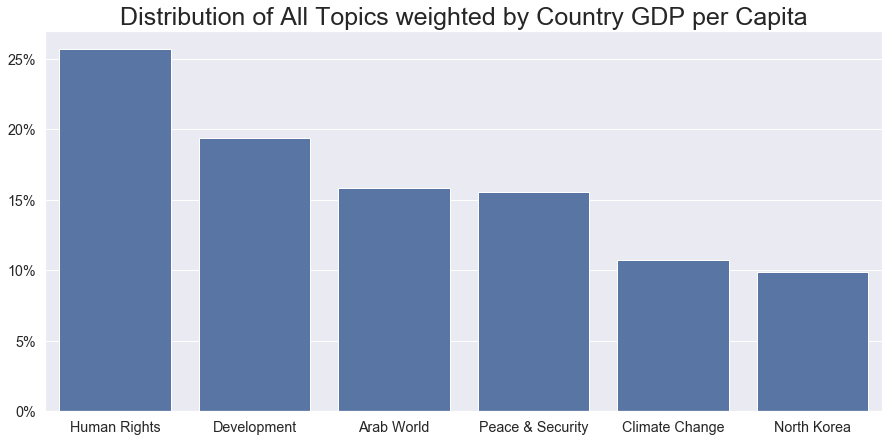

In [95]:
freq = weights.groupby('variable')
freq = pd.DataFrame({
    'weighted_value': freq['weighted_value'].sum()
    , 'sum_gdp': freq['gdp_per_capita'].sum()
}).reset_index()
freq['weighted_value'] = freq['weighted_value']/freq['sum_gdp']
del weights['weighted_value']
freq.rename(columns={'variable': 'topic'}, inplace=True)
freq = pd.merge(freq, relevant_topics, how='inner', on='topic').sort_values('weighted_value', ascending=False)
plot_bar(
    freq, 'theme', 'weighted_value', 'Distribution of All Topics weighted by Country GDP per Capita', 'all_top_fig2'
)

**More on Tableau.**

## Sandbox